In [1]:
import os
import re
import sys
import pdb
import ntpath
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy import optimize

import IPython
from IPython.core.debugger import set_trace

import librosa
import librosa.display
import madmom.features.beats as mmb

from map_io import load_map, load_template, save_map, save_words
from word import *
from map import Map
from label import *
from utils import *

In [44]:
# increase notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [60]:
%matplotlib inline

In [4]:
def plotAudioBeats(x, sr, hop_length, onset_bin, beat_sec, plot_mel=False):
    '''
    Plots mel spectrogram of audio x,
    onset strength and predicted beats in song
    '''
    figsize = (10,6)
    if plot_mel:
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=figsize)
        ax0 = ax[0]
    else:
        fig, ax = plt.subplots(nrows=1, figsize=figsize)
        ax0 = ax
    
    times = np.arange(len(onset_bin)) * (hop_length/sr)
    
    ax0.plot(times, librosa.util.normalize(onset_bin),
             label='Onset strength')
    ax0.vlines(beat_sec, 0, 1, alpha=0.5, color='r',
               linestyle='--', label='Beats')
    ax0.legend()
    
    if plot_mel:
        M = librosa.feature.melspectrogram(y=x, sr=sr, hop_length=hop_length)
        librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                                 y_axis='mel', x_axis='time', sr=sr, hop_length=hop_length,
                                 ax=ax[1])

        ax[1].label_outer()
        ax[1].set(title='Mel spectrogram')
    
    
    #plt.show(block=False)

In [5]:
def getBPMFromBeats(onset_bins, bin_len, method):
    '''Find potential bpm from beat positions in seconds'''
    if method == 'lr':
        when_beats = onset_bins * bin_len
        m_res = scipy.stats.linregress(np.arange(len(when_beats)),when_beats)
        first_beat = m_res.intercept 
        beat_step = m_res.slope
        pred_bpm = 60 / beat_step
        bpm_range = np.array([pred_bpm-5, pred_bpm+5])
    
    else: # quadratic interpolation
        onset_diffs = np.diff(onset_bins).astype(np.int)
        # sorted unique values and their counts
        uniqvals, counts = np.unique(onset_diffs, return_counts=True)
        est_dist = scipy.interpolate.interp1d(uniqvals, counts, 'quadratic')
        xnew = np.arange(uniqvals[0], uniqvals[-1], 0.01)
        ynew = est_dist(xnew)
        plt.plot(xnew, ynew)
        best_ibin = np.argmax(ynew)
        max_bin = xnew[best_ibin]
        pred_bpm = 60/(max_bin*bin_len)
        # bin peak bases
        irange = int(0.04/bin_len)*100
        pkrange = (max(best_ibin-irange, 0), min(best_ibin+irange, len(ynew)))
        # bpm ranges
        bpm_range = np.array([60/(xnew[pkrange[1]]*bin_len), 
                              60/(xnew[pkrange[0]]*bin_len)])

    # if bpm < 100, double it
    if pred_bpm < 100:
        pred_bpm *= 2
        bpm_range *= 2
    # if bpm > 300, halve it
    if pred_bpm > 300:
        pred_bpm = pred_bpm / 2
        bpm_range = bpm_range / 2
    # round bpm to 2 decimal places
    pred_bpm = np.around(pred_bpm, decimals=2)
    bpm_range = np.around(bpm_range, decimals=2)
    # if predicted bpm is very close to integer value, round
    bpm_shift = pred_bpm - round(pred_bpm)
    if abs(bpm_shift) < 0.05:
        pred_bpm = round(pred_bpm)
        bpm_range = bpm_range - bpm_shift
        
    return pred_bpm, bpm_range

In [6]:
def createTicks(time_bpm, est_end):
    '''
    Generate ticks based on bpm, offset, and meter
    If more than one bpm/offset section, generate those as well
    Generated ticks are in ms units if specified
    Inputs: time_bpm - list with N elements, each element is a
                       3x1 array with [offset, bpm, meter] info
            est_end - estimated ending of ticks (usually last onset)
    '''
    # get timing ticks
    ticks = np.array([])
    for i, ui in enumerate(time_bpm):
        
        begin_time = ui[0]
        bpm = ui[1]
        meter = ui[2]
        
        est_blen = 1/(bpm/60)
        
        if i < len(time_bpm)-1:
            end_time = time_bpm[i+1][0]
        else:
            end_time = est_end

        est_tlen = est_blen / meter
        endgap = (end_time - begin_time) % est_tlen
        end_time = end_time - endgap
        arr = np.arange(begin_time, end_time, est_tlen)
        ticks = np.append(ticks,arr)
    
    return ticks

In [92]:
def checkTicks(est_x, est_end, onset_times, verbose_f):
    '''
    Check if estimated bpm and offset match with actual song onsets
    Method: Generate the potential beats using estimated bpm and offset
            Match each beat with nearest song onset
            Calculate residual between the beat and nearest onset
            Remove outlier residuals and smooth residual curve
            Return mean abs residual to measure if simulated beat matches onsets
            
    Inputs: est_x - array of size 2, estimated bpm and estimated offset
            est_end - end range of generated ticks from bpm & offset
            onset_times - onset times found through librosa or mmb
                          objective to match with generated ticks
            verbose_f - whether or not to output stats and plot residual curve
    Outputs: res - mean abs residual between nearest onsets and simulated ticks
                   residual signal is smoothed
    '''
    est_bpm = est_x[0]
    est_offset = est_x[1]
    est_blen = 1/(est_bpm/60)
    est_tlen = est_blen/4  # assume meter is 4
    est_beats = np.arange(est_offset, est_end, est_blen)
    est_ticks = np.arange(est_offset, est_end, est_tlen)
    num_beats = len(est_beats)
    
    # matches each estimated beat with nearest onset time
    idx, res = findNearest(onset_times, est_beats)
    meanabsres = np.mean(np.abs(res))

    # remove spikes and smooth
    outres = reject_outliers(res, m = 2.)
    outmeanres = np.mean(outres)
    outmeanabsres = np.mean(np.abs(outres))
    outstdres = np.std(outres)
    
    # line fitted to first couple samples (for offset finding)
    first_samps = outres[:int(num_beats/4)]
    first_outs = reject_outliers(first_samps, m = 2.)
    # avg abs offset from 0 for first couple values (for offset finding)
    first_val = np.abs(np.mean(first_outs[:10]))
    
    outresx = np.arange(len(first_outs))
    outresy = first_outs
    lrres = scipy.stats.linregress(outresx,outresy)
    lrintercept = lrres.intercept
    lrslope = lrres.slope
    lrx = np.array([0, len(outres)])
    lry = lrslope * lrx + lrintercept
    lrscore = np.abs(lrslope) + np.abs(lrintercept) + first_val
                     
    #plotres = smooth(outres, win_size=51, method="sg")
    #smoothmeanabsres = np.mean(np.abs(plotres))

    if verbose_f:
        # outputs
        print('est beat length: ', est_blen, ' | est tick length: ', est_tlen)
        print('time range from ', est_offset, ' to ', est_end)
        print('num est beats: ', len(est_beats), ' | num est ticks: ', len(est_ticks))
        print('mean residual: ', np.mean(res), ' | mean abs residual: ', meanabsres)
        print('mean outlier-processed residual: ', outmeanres)
        print('stdev outlier-processed residual: ', outstdres)
        print('mean abs outlier-processed residual: ', outmeanabsres)
        print('lr intercept: ', lrintercept, ' | lr slope: ', lrslope)
        print('lr score: ', lrscore)
        print('first_val: ', first_val)
        
        #print('mean smoothed residual: ', np.mean(plotres))
        #print('mean abs smoothed residual: ', smoothmeanabsres)

        fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14,7))
        ax[0].plot(res)
        ax[1].plot(outres)
        ax[1].plot(lrx,lry,'-r')
    
    return outstdres, lrscore, outmeanabsres

In [8]:
def searchCombs(combs, xtype, metric, verbose_f, args):
    '''
    Search over bpm and offset combinations 
    to find best matching bpm and offset
    Inputs: combs - Nx2 array with N combinations
                    of bpm (col 0) and offset (col 1)
            metric - col of result metrics to optimize
            args - other arguments for checkTicks func
    '''
    
    results = []
    for cx in combs:
        cres = checkTicks(cx, *args)
        cres = np.array(cres)
        results.append(cres[np.newaxis,:])

    resarr = np.vstack(results)
    mc = resarr[:,metric]
    # normalize and average columns if more than one metric
    if len(metric) > 1:
        mc = (mc - np.min(mc,axis=0)) / (np.max(mc,axis=0) - np.min(mc,axis=0))
        mc = np.mean(mc, axis=1)
    bestx = combs[np.argmin(mc),:]
    
    if verbose_f:
        print('searching over ', combs.shape[0], ' combinations')
        
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
        ax[0].plot(combs[:,xtype], resarr[:,0])
        ax[1].plot(combs[:,xtype], resarr[:,1])
        ax[2].plot(combs[:,xtype], resarr[:,2])

        print('best [bpm, offset]: ', bestx)
        print('best metric: ', np.min(mc))
    
    return bestx

In [9]:
def searchLoop(bpm_bounds, offset_bounds, x0, args):
    '''Search over bpm and offset until convergence'''
    verbose_f = 0
    
    est_bpm = x0[0]
    est_offset = x0[1]
    est_blen = 1/(est_bpm/60)
    est_tlen = est_blen/4
    
    # rough search (0.1 bpm increments)
    potential_bpm = np.arange(bpm_bounds[0], bpm_bounds[1], 0.1)
    potential_offset = [est_offset]
    print('searching bpm range: ', bpm_bounds, ' with offset ', est_offset, ' and increment ', 0.1)
    combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
    # search using std of residual to narrow down bpm range
    bestcomb = searchCombs(combs, 0, [0], verbose_f, args)
    print('best comb: ', bestcomb)
    
    # search for offset (0.001 sec increments)
    potential_bpm = [bestcomb[0]]
    potential_offset = np.arange(offset_bounds[0], offset_bounds[1], 0.001)
    print('searching offset range: ', offset_bounds, ' with bpm ', bestcomb[0], ' and increment ', 0.001)
    combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
    # search using closeness of linear regression line to 0 slope and 0 intercept
    bestcomb2 = searchCombs(combs, 1, [0, 1], verbose_f, args)
    print('best comb: ', bestcomb2)
    
    # fine tuning
    # measure mean abs residual between predicted beats and librosa onsets
    used_metric = [2]
    
    # finer search (0.01 bpm increments)
    new_bounds = (bestcomb[0]-0.09, bestcomb[0]+0.09)
    potential_bpm = np.arange(new_bounds[0], new_bounds[1], 0.01)
    potential_offset = [bestcomb2[1]]
    print('searching bpm range: ', new_bounds, ' with offset ', bestcomb2[1], ' and increment ', 0.01)
    combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
    bestcomb3 = searchCombs(combs, 0, used_metric, verbose_f, args)
    final_bpm = bestcomb3[0]
    print('best comb: ', bestcomb3)
    
    # search for offset (0.001 sec increments)
    new_bounds = (max(0, bestcomb2[1]-est_tlen), bestcomb2[1]+est_tlen)
    potential_bpm = [final_bpm]
    potential_offset = np.arange(new_bounds[0], new_bounds[1], 0.001)
    print('searching offset range: ', new_bounds, ' with bpm ', final_bpm, ' and increment ', 0.001)
    combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
    bestcomb4 = searchCombs(combs, 1, used_metric, verbose_f, args)
    final_offset = bestcomb4[1]
    print('best comb: ', bestcomb4)
    
    plot_test = 1
    if plot_test:
        new_args = [args[0], args[1], 1]
        checkTicks(bestcomb, *new_args)
        checkTicks(bestcomb2, *new_args)
        checkTicks(bestcomb3, *new_args)
        checkTicks(bestcomb4, *new_args)
    
    return final_bpm, final_offset

In [103]:
def getLibrosaBPM(mp3_file, hop=256):
    '''
    Use librosa onsets library to guess BPM of song
    Returns: list of tuples (offset, bpm, meter) 
             for each section of song with different bpm
    '''
    x, sr = librosa.load(mp3_file, sr=None, mono=True)
    song_sec = len(x) / sr
    
    # librosa onset
    onset_frames = librosa.onset.onset_detect(x, sr=sr, hop_length=hop)
    onset_times = onset_frames * (hop / sr)
    o_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop)
    
    # plot onset strength
    #plt.figure(figsize=(14,7))
    #times = np.arange(len(o_env)) * (hop/sr)
    #plt.plot(times, librosa.util.normalize(o_env), label='Onset strength')
    #plt.vlines(onset_times, 0, 1, alpha=0.5, color='r',
    #           linestyle='--', label='onsets')
    
    # quadratic interpolation of beat frame diff histogram
    quad_bpm, bpm_range = getBPMFromBeats(onset_frames, (hop / sr), 'quad')
    print("quad estimated bpm: ", quad_bpm)
    print("quad estimated bpm range: ", bpm_range)
    
    # simulate ticks using estimated bpm and offset
    est_bpm = quad_bpm
    est_offset = onset_times[0]
    est_end = min(onset_times[-1]+1, song_sec)

    est_blen = 1/(est_bpm/60)
    est_tlen = est_blen/4

    # specify search bounds for bpm and offset
    x0 = np.array([est_bpm, est_offset])
    bpm_bounds = [est_bpm-10, est_bpm+10]
    offset_bounds = (max(0, est_offset-est_tlen*2), est_offset+est_tlen*2)

    print("initial bpm, initial offset: ", x0)
    print("ticks end (seconds): ", est_end)
    print("bpm search range: ", bpm_bounds)
    print("offset search range: ", offset_bounds)
    
    # arguments for checkTicks function
    args = (est_end, onset_times, 0)
    # search over bounds to find optimal bpm and offset
    final_bpm, final_offset = searchLoop(bpm_bounds, offset_bounds, x0, args)
    
    # finalize outputs
    final_offset = np.around(final_offset, decimals=3)
    final_offset = int(final_offset*1000)
    final_bpm = np.around(final_bpm, decimals=2)
    
    # if predicted bpm is very close to integer value, round
    bpm_shift = final_bpm - round(final_bpm)
    if abs(bpm_shift) < 0.06:
        final_bpm = round(final_bpm)
    
    # final results
    print('[offset bpm meter]: ', final_offset, final_bpm, 4)
    
    time_bpm = []
    # always assume meter 4
    # offset in ms
    time_bpm.append([final_offset, final_bpm, 4])
    
    return time_bpm

In [120]:
def checkOffsetLibrosa(mp3_file, bpm, hop=2205):
    '''
    Use larger hop length to fine tune song offset
    Returns: list of tuples (offset, bpm, meter) 
             for each section of song with different bpm
    '''
    print('constructing onsets with window hop ', hop)
    
    x, sr = librosa.load(mp3_file, sr=None, mono=True)
    song_sec = len(x) / sr
    
    # librosa onset
    onset_frames = librosa.onset.onset_detect(x, sr=sr, hop_length=hop)
    onset_times = onset_frames * (hop / sr)
    
    # simulate ticks using estimated bpm and offset
    est_bpm = bpm
    est_offset = onset_times[0]
    est_end = min(onset_times[-1]+1, song_sec)

    est_blen = 1/(est_bpm/60)
    est_tlen = est_blen/4

    # specify search bounds for bpm and offset
    x0 = np.array([est_bpm, est_offset])
    bpm_bounds = (est_bpm, est_bpm)
    offset_bounds = (max(0, est_offset-est_tlen*2), est_offset+est_tlen*2)

    print("initial bpm, initial offset: ", x0)
    print("ticks end (seconds): ", est_end)
    print("bpm search range: ", bpm_bounds)
    print("offset search range: ", offset_bounds)
    
    # arguments for checkTicks function
    args = (est_end, onset_times, 0)
    
    
    # search over bounds to find optimal bpm and offset
    verbose_f = 0
    
    final_bpm = x0[0]
    est_offset = x0[1]
    est_blen = 1/(est_bpm/60)
    est_tlen = est_blen/4
    
    # search for offset (0.001 sec increments)
    potential_bpm = [est_bpm]
    potential_offset = np.arange(offset_bounds[0], offset_bounds[1], 0.001)
    print('searching offset range: ', offset_bounds, ' with bpm ', final_bpm, ' and increment ', 0.001)
    combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
    bestcomb = searchCombs(combs, 1, [1, 2], verbose_f, args)
    final_offset = bestcomb[1]
    print('best comb: ', bestcomb)
    
    plot_test = 1
    if plot_test:
        new_args = [args[0], args[1], 1]
        checkTicks(bestcomb, *new_args)
    
    # finalize outputs
    final_offset = np.around(final_offset, decimals=3)
    final_offset = int(final_offset*1000)
    
    # final results
    print('[offset bpm meter]: ', final_offset, final_bpm, 4)
    
    time_bpm = []
    # always assume meter 4
    # offset in ms
    time_bpm.append([final_offset, final_bpm, 4])
    
    return time_bpm

In [37]:
def getBestShifts(time_bpm, ms_ticks, label_arr, bin_in_sec, N, crop_sec):
    
    # modify offsets to match
    best_shifts = []
    for i, section in enumerate(time_bpm):
        if i == len(time_bpm)-1:
            rg = (section[0], crop_sec*1000)
        else:
            rg = (section[0], time_bpm[i+1][0])
        
        section_ticks = ms_ticks[np.bitwise_and(ms_ticks >= rg[0], ms_ticks < rg[1])]
        
        # range of ms shifts to search over
        check_range = np.arange(-500, 501)
        check_sum = np.zeros(check_range.shape)
        for ci, cdiff in enumerate(check_range):
            new_ticks = section_ticks+cdiff
            new_ticks = new_ticks[new_ticks >= 0]
            tbi = getTickBins(new_ticks, bin_in_sec, N)
            check_sum[ci] = label_arr[tbi].sum()

        # smooth sums to find peak of curves
        sumsmooth = smooth(check_sum, win_size=31, method="sg")
        pkidx, pkdict = scipy.signal.find_peaks(sumsmooth, prominence=np.ptp(sumsmooth)/10)
        pkshifts = check_range[pkidx]
        best_shift = check_range[pkidx[np.argmin(np.abs(pkshifts))]]

        plt.plot(check_range, check_sum)
        plt.plot(check_range, sumsmooth)
        plt.vlines(best_shift, np.min(sumsmooth), np.max(sumsmooth),
                   alpha=0.5, color='r', linestyle='--', label='best shift')
        print('best tick shift: ', best_shift)
        
        best_shifts.append(best_shift)
    
    return best_shifts

In [38]:
def checkOffsetLabels(mp3_file, arr_file, time_bpm):
    '''Use model prediction spectrogram bin outputs to guess bpm range of song'''
    sec_len = librosa.get_duration(filename=mp3_file)
    mp3_len = sec_len * 1000
    
    # check offset using model predictions
    # requires model predictions
    label_arr, crop_sec = loadModelPred(arr_file, sec_len)
    
    # spectrogram bins (default 0.032 seconds)
    N = len(label_arr)
    bin_len = crop_sec / (N-1)  # length of each time bin in seconds
    bin_in_sec = 1 / bin_len  # number of bins in every second

    #labels = np.copy(label_arr)
    #thresh = 0.1
    #labels[labels > thresh] = 1
    #labels[labels <= thresh] = 0
    #labels = labels.astype(np.uint8)
    
    sec_bpm = [x[:] for x in time_bpm]
    for i, section in enumerate(time_bpm):
        sec_bpm[i][0] = section[0]/1000
    
    new_ticks = createTicks(sec_bpm, sec_len)
    ms_ticks = new_ticks * 1000
    
    best_shifts = getBestShifts(time_bpm, ms_ticks, label_arr, bin_in_sec, N, crop_sec)
    
    final_sections = [x[:] for x in time_bpm]
    for i, section in enumerate(final_sections):
        section[0] = section[0] + best_shifts[i]
        
    print('final time sections: ', final_sections)
    
    return final_sections

constructing onsets with window hop  1411


C:\Anaconda3\envs\osumap\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial bpm, initial offset:  [190.          0.6173125]
ticks end (seconds):  211.91510416666665
bpm search range:  (190.0, 190.0)
offset search range:  (0.45941776315789473, 0.7752072368421054)
searching offset range:  (0.45941776315789473, 0.7752072368421054)  with bpm  190.0  and increment  0.001
best comb:  [190.           0.59541776]
est beat length:  0.31578947368421056  | est tick length:  0.07894736842105264
time range from  0.5954177631578949  to  211.91510416666665
num est beats:  670  | num est ticks:  2677
mean residual:  -0.016915851662746412  | mean abs residual:  0.19578951950772575
mean outlier-processed residual:  0.0010459703947302786
stdev outlier-processed residual:  0.013791130463246294
mean abs outlier-processed residual:  0.010653892543860647
lr intercept:  0.000596820369790191  | lr slope:  1.2318396965276481e-05
lr score:  0.0006833712228955228
first_val:  7.423245614005536e-05
[offset bpm meter]:  595 190.0 4
checked offset:  [[595, 190.0, 4]]


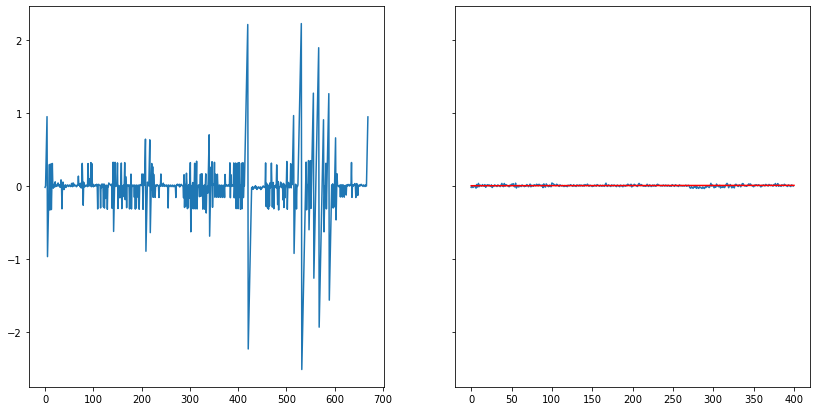

In [121]:
# get song
#filename = "umu. - humanly (Half) [Len's Robotically Another]"
#filename = "Our Stolen Theory - United (L.A.O.S Remix) (Asphyxia) [Infinity]"
#filename = "Will Stetson - Despacito ft. R3 Music Box (Sotarks) [Monstrata's Slow Expert]"
#filename = "YOASOBI - Ano Yume o Nazotte (Sarawatlism) [Daisuki]"
#filename = "Caravan Palace - Miracle (Mulciber) [Extra]"
#filename = "xi - FREEDOM DiVE (Pikastar) [Universe]"
#filename = "DM Ashura - Classical Insanity (Louis Cyphre) [Vivacissimo]"
filename = "Die For You ft. Grabbitz  - VCT 2021"
#filename = "Train - 50 Ways to Say Goodbye"
#filename = "Nightcore - Dernière Danse"

#filename = "The Quick Brown Fox - The Big Black (Blue Dragon) [WHO'S AFRAID OF THE BIG BLACK]"
#filename = "YOASOBI - Yoru ni Kakeru (CoLouRed GlaZeE) [Collab Extra]"
#filename = "AKINO from bless4 & CHiCO with HoneyWorks - MIIRO vs. Ai no Scenario (monstrata) [Tatoe]"
#filename = "GALNERYUS - RAISE MY SWORD (beem2137) [Feruver's Expert]"
#filename = "SakiZ - osu!memories (DeRandom Otaku) [Happy Memories]"
#filename = "Wan Ho-Kit, Lee Hon-Kam - Unknown Title (Monstrata) [Let's show them Monstrata's powerful stance.]"

# [Time(ms), bpm, meter(beats per measure)]
# bpm = 1 / [tick_length] * 1000 * 60

# check if predicted offset and BPM are close to actual song values
#time_bpm = [[983,250,4]]
#time_bpm = [[15688, 175, 4]]
#time_bpm = [[540,91,4],[2245,89,4]]
#time_bpm = [[1342,180,4]]
#time_bpm = [[-30,200,4]]
#time_bpm = [[2133,222.22,4]]
#time_bpm = [[38,175,4],[64152,175,3],[75466,175,4]]
time_bpm = [[5620,190,4]]
#time_bpm = [[430,140,4]]
#time_bpm = [[590,132.25,4]]

#time_bpm = [[6966,360.3,4]]
#time_bpm = [[1040,130,4]]
#time_bpm = [[0,195,4],[55692,180,4]]
#time_bpm = cluster fuck mostly [[792,184,4]] sometimes 183-185
#time_bpm = 180 until 240
#time_bpm = ~190 and gradually speeds up until ~212 bpm

osu_file = "songs/osu_mp3/" + filename + ".osu"
mp3_file = "songs/osu_mp3/" + filename + ".mp3"
wav_file = "songs/osu_mp3/" + filename + ".wav"
arr_file = "songs/osu_mp3/" + filename + ".npy"

# use hit object predictions from model to get potential bpm ranges
# the faster the song is and the closer tick diffs are to bin length (0.032 sec),
# the wider the possible bpm range
#model_range, model_conf = getModelBPM(mp3_file, arr_file)

# use librosa onset detector to get potential bpm ranges
#time_bpm = getLibrosaBPM(mp3_file)
#print(time_bpm)
time_bpm = checkOffsetLibrosa(mp3_file, 190.0, hop=1411)
print('checked offset: ', time_bpm)

# use rnn beat tracker
#mmb_sections = getMmbBPM(mp3_file)

best tick shift:  30
final time sections:  [[631, 190.0, 4]]


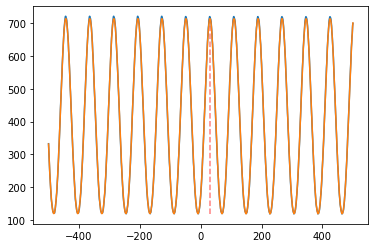

In [101]:
final_sections = checkOffsetLabels(mp3_file, arr_file, time_bpm)
#final_sections = checkOffsetLabels(mp3_file, arr_file, [[15688, 175, 4]])

In [102]:
### Experiment 1: Create map from audio file and predicted labels

sec_len = librosa.get_duration(filename=mp3_file)
mp3_len = sec_len * 1000
m_empty = Map.fromTiming(final_sections,mp3_file,mp3_len=mp3_len)
#m_empty = Map.fromTiming([[5620,190,4]],mp3_file,mp3_len=mp3_len)

label_arr, crop_sec = loadModelPred(arr_file, sec_len)

obj_words = m_empty.encodeHitLabels2Map(crop_sec, label_arr)
m_empty.decodeWords(obj_words)
m_empty.saveMap2Osu()

best tick shift:  0
songs/Die For You ft. Grabbitz  - VCT 2021 [AIs Easy].osu written successfully


In [69]:
%matplotlib inline

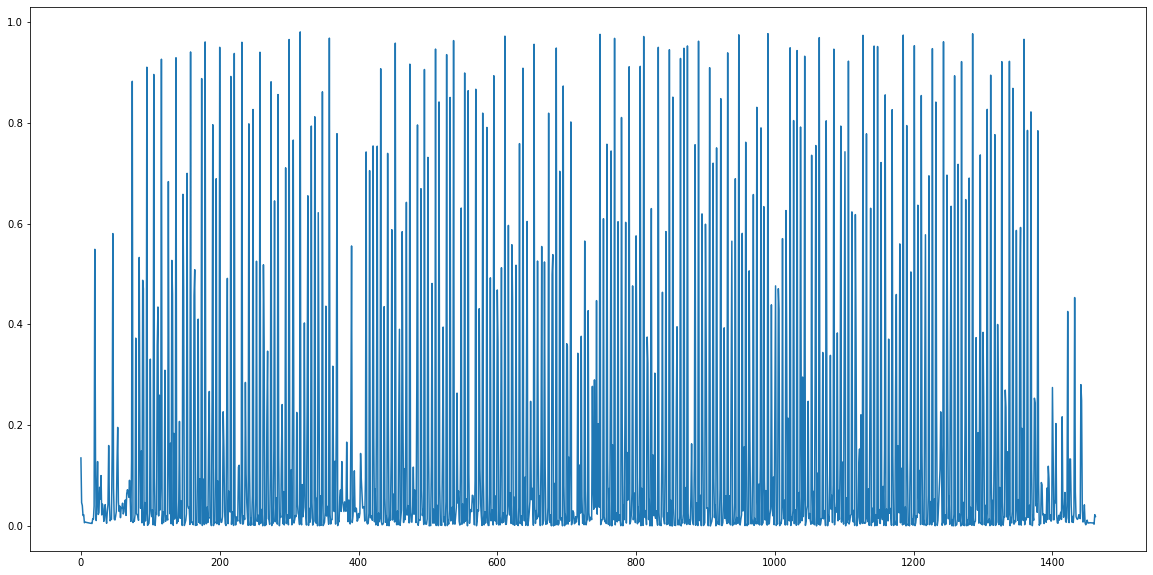

In [65]:
label_arr, crop_sec = loadModelPred(arr_file, sec_len)
plt.figure(figsize=(20,10))
plt.plot(label_arr)

C:\Anaconda3\envs\osumap\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(20.0, 40.0)

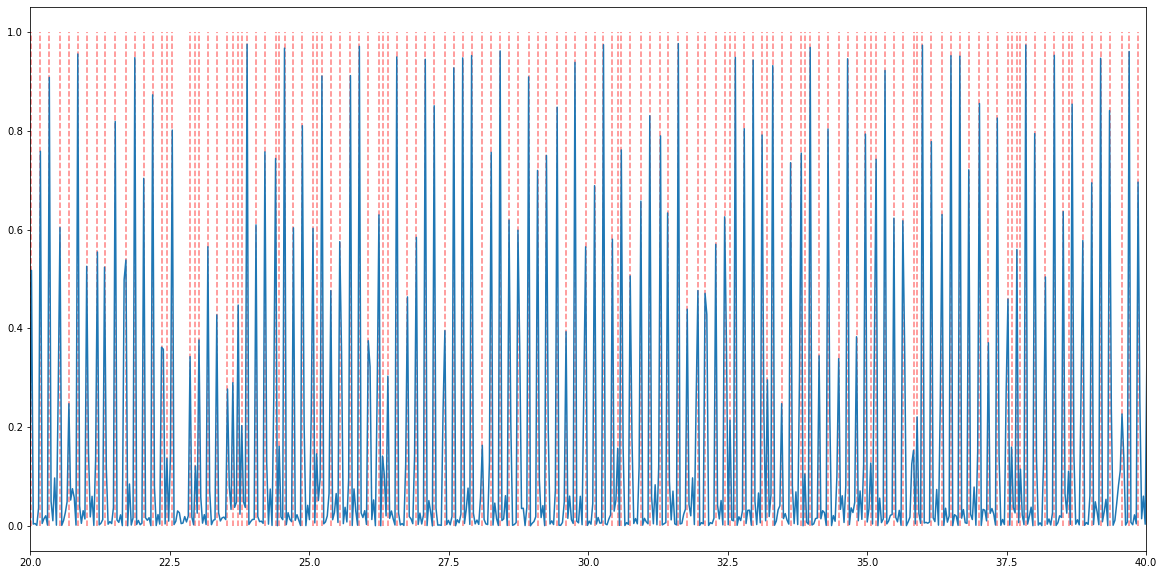

In [90]:
# model onset
x, sr = librosa.load(mp3_file, sr=None, mono=True)
song_sec = crop_sec

N = len(label_arr)
bin_len = crop_sec / (N-1)  # length of each time bin in seconds
bin_in_sec = 1 / bin_len  # number of bins in every second

hop = bin_len*sr
onset_frames, onset_dict = scipy.signal.find_peaks(label_arr.flatten(), height=0.1)
onset_times = onset_frames * (hop / sr)

# plot onset strength
plt.figure(figsize=(20,10))
times = np.arange(N) * (hop/sr)
plt.plot(times, label_arr, label='Onset strength')
plt.vlines(onset_times, 0, 1, alpha=0.5, color='r',
           linestyle='--', label='onsets')
plt.xlim((20,40))

quad estimated bpm:  184.2
quad estimated bpm range:  [154.   229.13]


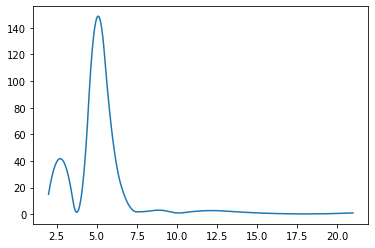

In [88]:
# quadratic interpolation of beat frame diff histogram
quad_bpm, bpm_range = getBPMFromBeats(onset_frames, (hop / sr), 'quad')
print("quad estimated bpm: ", quad_bpm)
print("quad estimated bpm range: ", bpm_range)

initial bpm, initial offset:  [184.2          0.63868673]
ticks end (seconds):  46.688
bpm search range:  [174.2, 194.2]
offset search range:  (0.4758202809947553, 0.8015531800175566)
searching bpm range:  [174.2, 194.2]  with offset  0.638686730506156  and increment  0.1
best comb:  [178.4          0.63868673]
searching offset range:  (0.4758202809947553, 0.8015531800175566)  with bpm  178.39999999999975  and increment  0.001
best comb:  [178.4          0.67782028]
searching bpm range:  (178.30999999999975, 178.48999999999975)  with offset  0.6778202809947556  and increment  0.01
best comb:  [178.42         0.67782028]
searching offset range:  (0.5963870562390552, 0.7592535057504559)  with bpm  178.41999999999965  and increment  0.001
best comb:  [178.42         0.67838706]
est beat length:  0.3363228699551574  | est tick length:  0.08408071748878936
time range from  0.638686730506156  to  46.688
num est beats:  137  | num est ticks:  548
mean residual:  -0.02836271577638997  | mean a

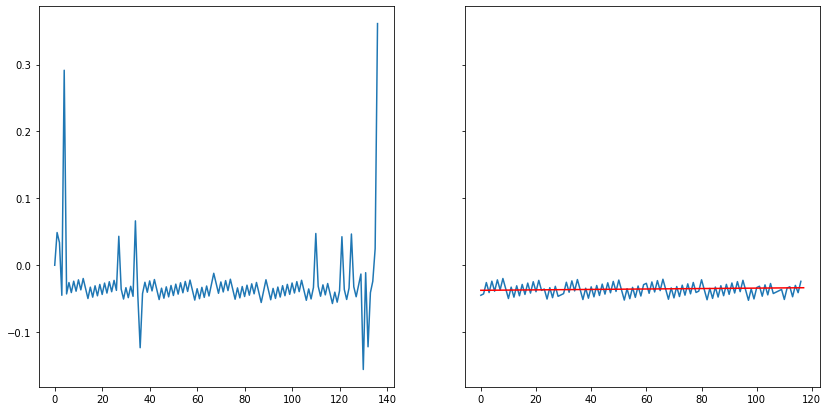

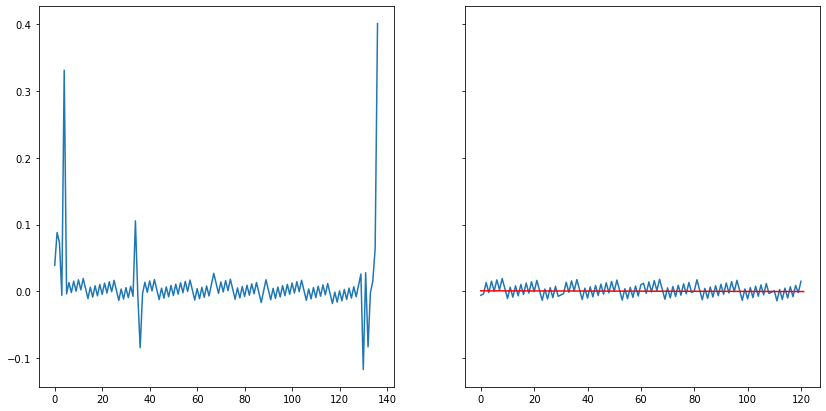

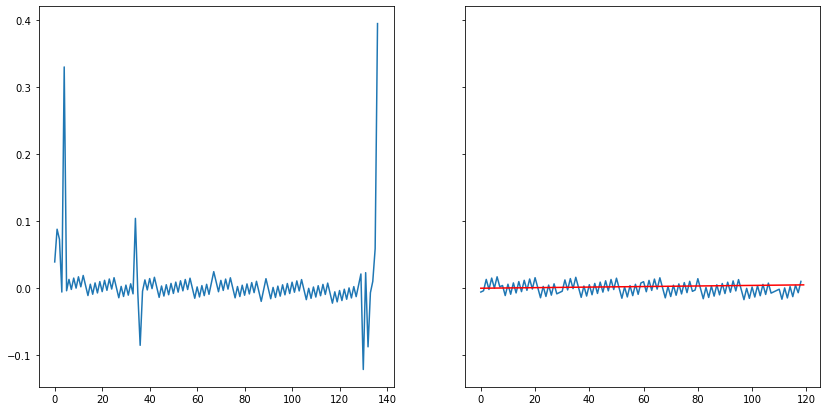

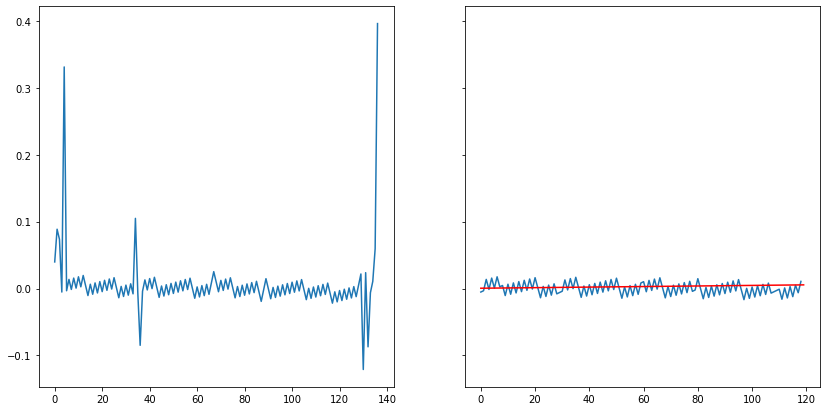

In [93]:
# simulate ticks using estimated bpm and offset
est_bpm = quad_bpm
est_offset = onset_times[0]
est_end = min(onset_times[-1]+1, song_sec)

est_blen = 1/(est_bpm/60)
est_tlen = est_blen/4

# specify search bounds for bpm and offset
x0 = np.array([est_bpm, est_offset])
bpm_bounds = [est_bpm-10, est_bpm+10]
offset_bounds = (max(0, est_offset-est_tlen*2), est_offset+est_tlen*2)

print("initial bpm, initial offset: ", x0)
print("ticks end (seconds): ", est_end)
print("bpm search range: ", bpm_bounds)
print("offset search range: ", offset_bounds)

# arguments for checkTicks function
args = (est_end, onset_times, 0)
# search over bounds to find optimal bpm and offset
final_bpm, final_offset = searchLoop(bpm_bounds, offset_bounds, x0, args)

In [521]:
# load song
x, sr = librosa.load(mp3_file, sr=None, mono=True)
song_sec = len(x) / sr

C:\Anaconda3\envs\osumap\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
# default 100 frames per second
fps = 160
bin_len = 1/fps # length of each time bin in seconds
act = mmb.RNNBeatProcessor(fps=fps)(mp3_file)
# accurate estimation from here: https://github.com/CPJKU/madmom/issues/416
when_beats = mmb.BeatTrackingProcessor(fps=fps)(act)
diff_beats = np.diff(when_beats)

In [ ]:
# plot beats and audio
plotAudioBeats(x, sr, int(bin_len*sr), act, when_beats)

In [66]:
sections = []
num_beats = len(when_beats)

# check if entire song is regular
onset_bins = (when_beats * fps).astype(np.int)
diff_bins = (diff_beats * fps).astype(np.int)

median_diff = np.median(diff_bins)
mask = np.abs(diff_bins - median_diff)
mask = np.bitwise_or(mask <= 1, np.abs(mask-median_diff) <= 1)

quad_bpm = getBPMFromBeats(onset_bins, bin_len, 'quad')
print("quadratic estimated bpm: ", quad_bpm)

quadratic estimated bpm:  132.12


In [69]:
linreg_bpm = getBPMFromBeats(onset_bins, bin_len, 'lr')
print("lin regression estimated bpm: ", linreg_bpm)
est_bpm = np.around((quad_bpm+linreg_bpm)/2, decimals=2)
print("estimated bpm: ", est_bpm)

lin regression estimated bpm:  132.26
estimated bpm:  132.19


(20.0, 40.0)

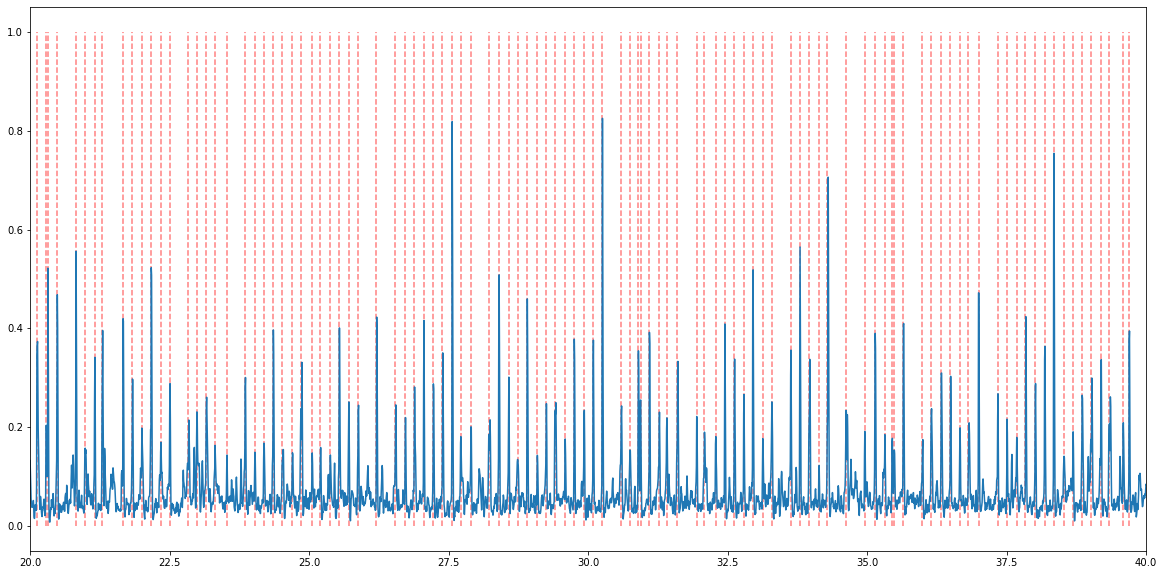

In [85]:
# librosa onset
hop = 256   
onset_frames = librosa.onset.onset_detect(x, sr=sr, hop_length=hop)
onset_times = onset_frames * (hop / sr)
o_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop)
#plot onset strength

plt.figure(figsize=(20,10))
times = np.arange(len(o_env)) * (hop/sr)
plt.plot(times, librosa.util.normalize(o_env), label='Onset strength')
plt.vlines(onset_times, 0, 1, alpha=0.5, color='r',
           linestyle='--', label='onsets')
plt.xlim((20,40))

quad estimated bpm:  180.07
quad estimated bpm range:  [148.93 227.66]


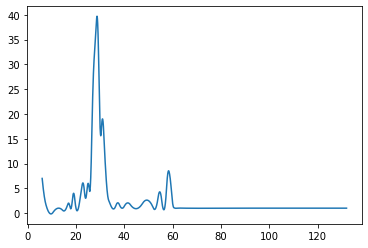

In [86]:
quad_bpm, bpm_range = getBPMFromBeats(onset_frames, (hop / sr), 'quad')
print("quad estimated bpm: ", quad_bpm)
print("quad estimated bpm range: ", bpm_range)

In [486]:
onset_times[:20]

array([0.04063492, 0.23800454, 0.37732426, 0.48761905, 0.65015873,
       0.79528345, 0.8707483 , 0.9752381 , 1.14938776, 1.31773243,
       1.39900227, 1.59056689, 1.77052154, 1.93306122, 2.06077098,
       2.13043084, 2.2523356 , 2.44970522, 2.59482993, 2.76897959])

In [524]:
# simulated ticks using estimated bpm and offset

est_bpm = quad_bpm
est_offset = onset_times[0]
est_end = min(onset_times[-1]+1, song_sec)

est_blen = 1/(est_bpm/60)
est_tlen = est_blen/4

print('estimated beat length: ', est_blen)
print('estimated tick length: ', est_tlen)

# specify bounds for bpm and offset
# checkTicks(est_x, est_end, onset_times, verbose_f)
x0 = np.array([est_bpm, est_offset])
bpm_bounds = [est_bpm-10, est_bpm+10]
offset_bounds = (max(0, est_offset-est_tlen*2), est_offset+est_tlen*2)

print("est_bpm, est_offset: ", x0)
print("ticks end (seconds): ", est_end)
print("bpm search range: ", bpm_bounds)
print("offset search range: ", offset_bounds)

estimated beat length:  0.21443888491779844
estimated tick length:  0.05360972122944961
est_bpm, est_offset:  [279.8          0.42376417]
ticks end (seconds):  244.96625850340138
bpm search range:  [269.8, 289.8]
offset search range:  (0.3165447298767017, 0.5309836147945002)


searching bpm range:  [269.8, 289.8]  with offset  0.42376417233560093  and increment  0.1
searching offset range:  (0.3165447298767017, 0.5309836147945002)  with bpm  280.00000000000233  and increment  0.001
searching bpm range:  (279.9000000000023, 280.10000000000235)  with offset  0.4495447298767018  and increment  0.01
searching offset range:  (0.3959350086472522, 0.5031544511061514)  with bpm  280.0000000000022  and increment  0.001
searching offset range:  (0.401, 0.501)  with bpm  280.0  and increment  0.001
searching over  100  combinations
best [bpm, offset]:  [280.      0.452]
best metric:  0.0035642242136718475
[280.      0.452]


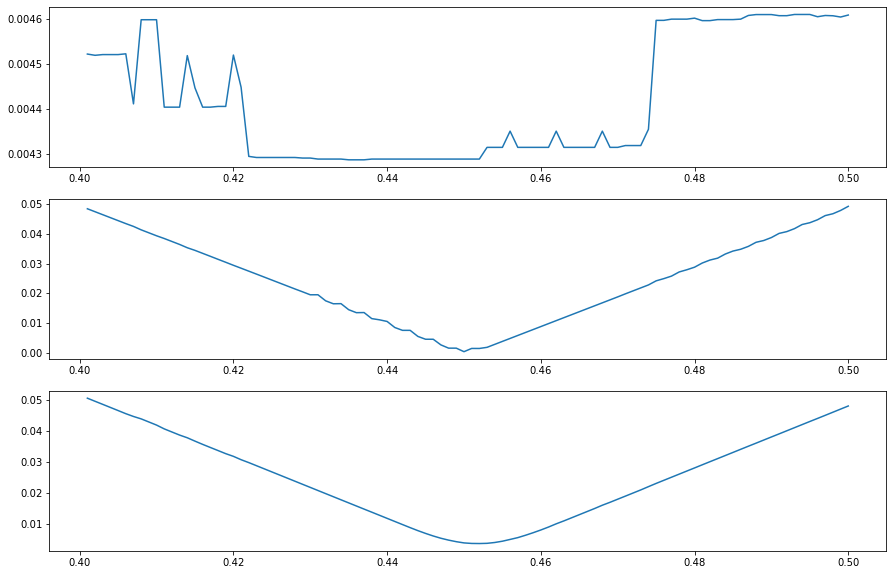

In [525]:
# arguments for checkTicks function
args = (est_end, onset_times, 0)
# search over bounds to find optimal bpm and offset
final_bpm, final_offset = searchLoop(bpm_bounds, offset_bounds, x0, args)

# double check offset using different hop length
hop = int(sr/100)
onset_frames2 = librosa.onset.onset_detect(x, sr=sr, hop_length=hop)
onset_times2 = onset_frames2 * (hop / sr)

new_bounds = (max(0, final_offset-0.05), final_offset+0.05)
potential_bpm = [final_bpm]
potential_offset = np.arange(new_bounds[0], new_bounds[1], 0.001)
print('searching offset range: ', new_bounds, ' with bpm ', final_bpm, ' and increment ', 0.001)
combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
bestcomb = searchCombs(combs, 1, used_metric, 1, (est_end, onset_times2, 0))
final_offset = bestcomb[1]
print(bestcomb)

searching bpm range:  [169.63, 189.63]  with increment  0.1
searching over  200  combinations
best [bpm, offset]:  [179.93         1.30666667]
best metric:  0.07561577236109072
est beat length:  0.33401992985581475  | est tick length:  0.08350498246395369
time range from  1.3066666666666666  to  238.20533333333333
num est beats:  711  | num est ticks:  1614
mean residual:  0.004221137933673979  | mean abs residual:  0.27021734331283703
mean outlier-processed residual:  -0.015902225290566348
stdev outlier-processed residual:  0.07561577236109072
mean abs outlier-processed residual:  0.053625958621643766
lr intercept:  -0.05020664106373089  | lr slope:  6.275708195775334e-05
lr score:  0.05026939814568865
first_val:  0.04670319939234548


(0.07561577236109072, 0.05026939814568865, 0.053625958621643766)

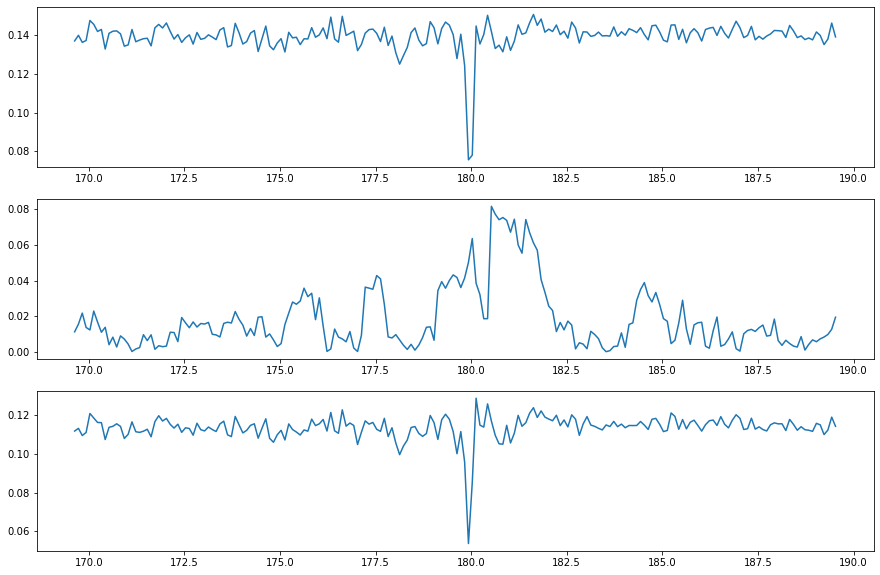

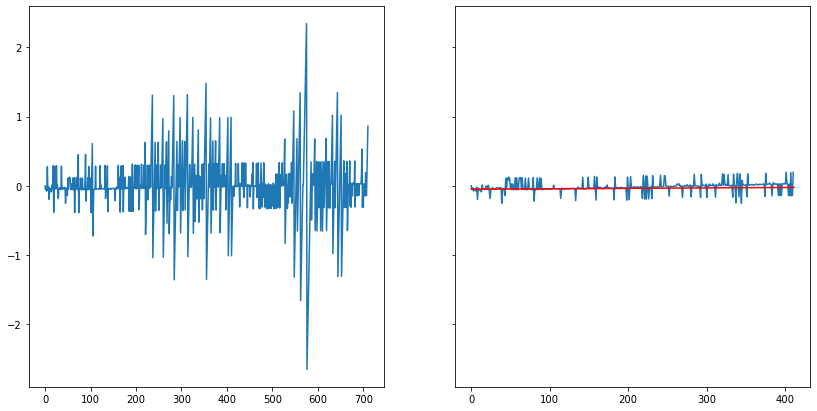

In [508]:
# rough search (0.1 bpm increments)
potential_bpm = np.arange(bpm_bounds[0], bpm_bounds[1], 0.1)
potential_offset = [est_offset]
combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
print('searching bpm range: ', bpm_bounds, ' with increment ', 0.1)
# search using mean abs residual
bestcomb = searchCombs(combs, 0, 0, 1, (est_end, onset_times, 0))
# verify best found
checkTicks(bestcomb, est_end, onset_times, 1)

searching offset range:  (1.1396567017387593, 1.473676631594574)  with increment  0.001
searching over  335  combinations
best [bpm, offset]:  [179.93        1.3586567]
best metric:  0.0003551513830532605
est beat length:  0.33401992985581475  | est tick length:  0.08350498246395369
time range from  1.3586567017387352  to  238.20533333333333
num est beats:  711  | num est ticks:  1614
mean residual:  -0.016880247528717154  | mean abs residual:  0.27098574923888225
mean outlier-processed residual:  0.008476444451858812
stdev outlier-processed residual:  0.1061056459990337
mean abs outlier-processed residual:  0.07326777790485361
lr intercept:  0.00027143974105062457  | lr slope:  8.371164200263596e-05
lr score:  0.0003551513830532605
first_val:  0.003133227795177396


(0.1061056459990337, 0.0003551513830532605, 0.07326777790485361)

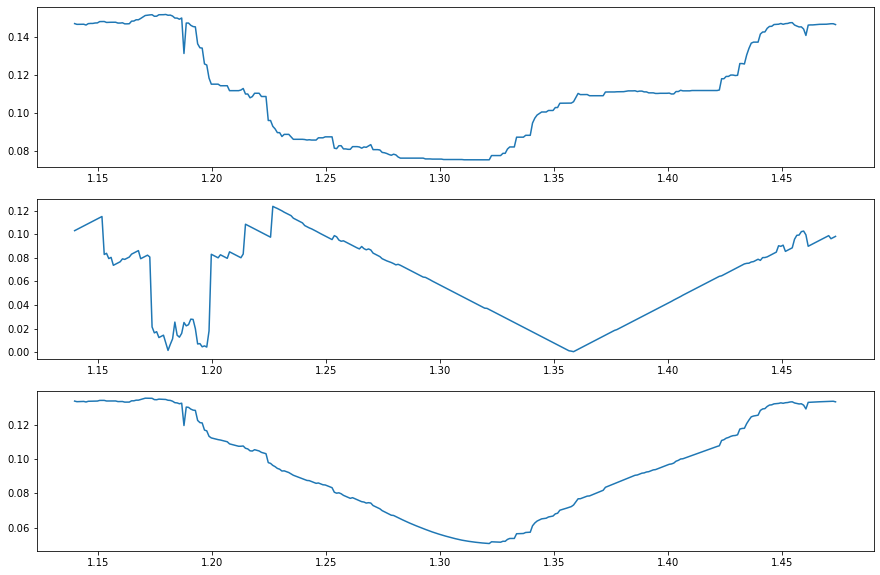

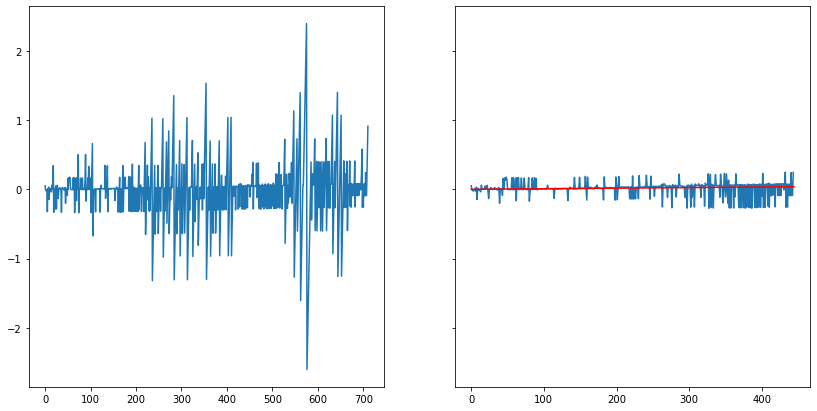

In [509]:
# search for offset (0.001 sec increments)
potential_bpm = [bestcomb[0]]
potential_offset = np.arange(offset_bounds[0], offset_bounds[1], 0.001)
print('searching offset range: ', offset_bounds, ' with increment ', 0.001)
combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
bestcomb2 = searchCombs(combs, 1, 1, 1, (est_end, onset_times, 0))

checkTicks(bestcomb2, est_end, onset_times, 1)

searching bpm range:  (178.9299999999994, 180.9299999999994)  with increment  0.01
searching over  200  combinations
best [bpm, offset]:  [179.99        1.3586567]
best metric:  0.04547228062699872
est beat length:  0.33401992985581475  | est tick length:  0.08350498246395369
time range from  1.3586567017387352  to  238.20533333333333
num est beats:  711  | num est ticks:  1614
mean residual:  0.03206658409843136  | mean abs residual:  0.26335651133559657
mean outlier-processed residual:  -0.004261246239963789
stdev outlier-processed residual:  0.08709705252754407
mean abs outlier-processed residual:  0.04547228062699872
lr intercept:  -0.008435998718343076  | lr slope:  1.1839240199293054e-05
lr score:  0.008447837958542368
first_val:  0.006678468733657539


(0.08709705252754407, 0.008447837958542368, 0.04547228062699872)

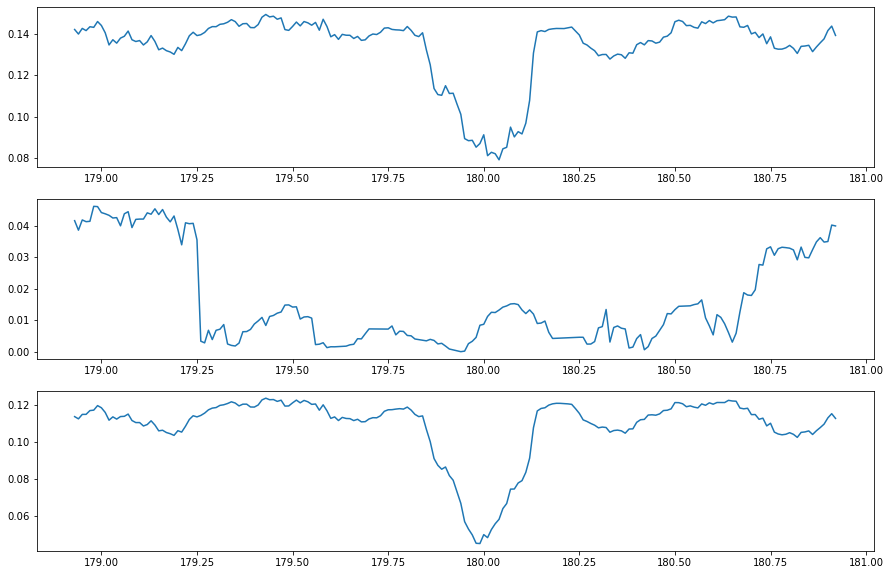

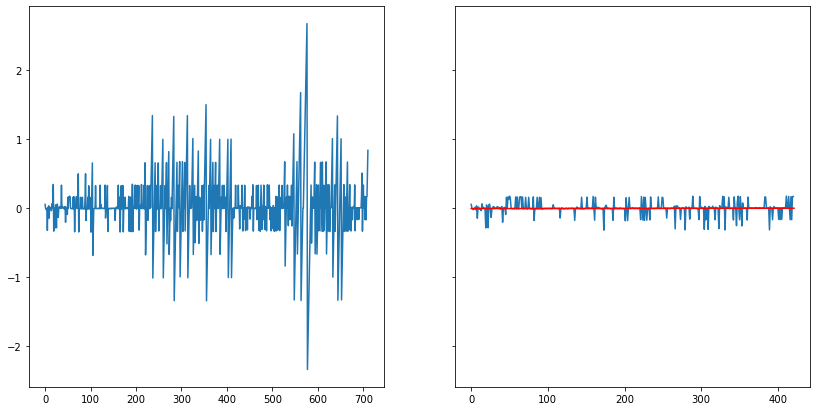

In [510]:
# finer search (0.01 bpm increments)
used_metric = 2

new_bounds = (bestcomb2[0]-1, bestcomb2[0]+1)
potential_bpm = np.arange(new_bounds[0], new_bounds[1], 0.01)
potential_offset = [bestcomb2[1]]
print('searching bpm range: ', new_bounds, ' with increment ', 0.01)
combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
bestcomb3 = searchCombs(combs, 0, used_metric, 1, (est_end, onset_times, 0))
final_bpm = bestcomb3[0]

checkTicks(bestcomb3, est_end, onset_times, 1)

searching over  84  combinations
best [bpm, offset]:  [179.99         1.35990421]
best metric:  0.04511001724863798
est beat length:  0.33401992985581475  | est tick length:  0.08350498246395369
time range from  1.3599042105067536  to  238.20533333333333
num est beats:  711  | num est ticks:  1614
mean residual:  0.026720562627349  | mean abs residual:  0.2632149870976681
mean outlier-processed residual:  -0.0030137374719461795
stdev outlier-processed residual:  0.08709705252754417
mean abs outlier-processed residual:  0.04511001724863798
lr intercept:  -0.007188489950323972  | lr slope:  1.1839240199267941e-05
lr score:  0.00720032919052324
first_val:  0.005430959965639004


(0.08709705252754417, 0.00720032919052324, 0.04511001724863798)

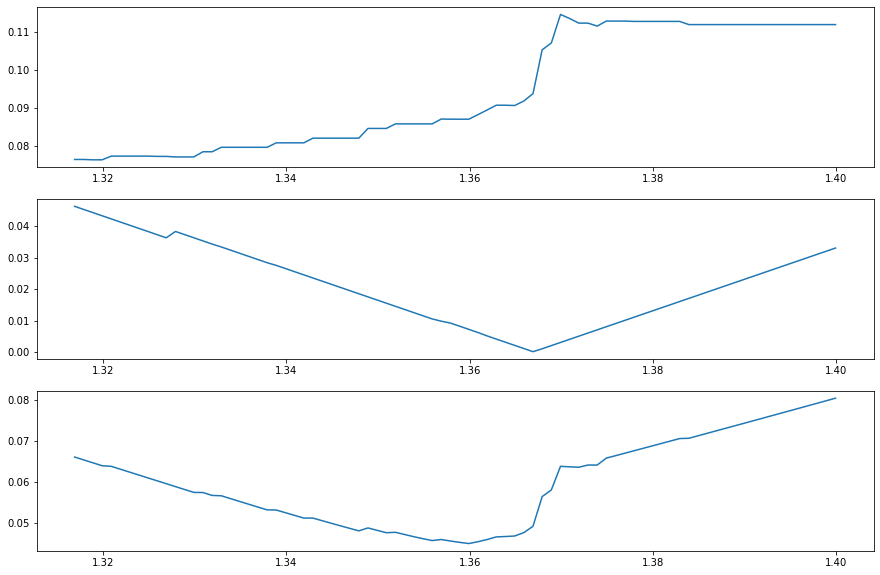

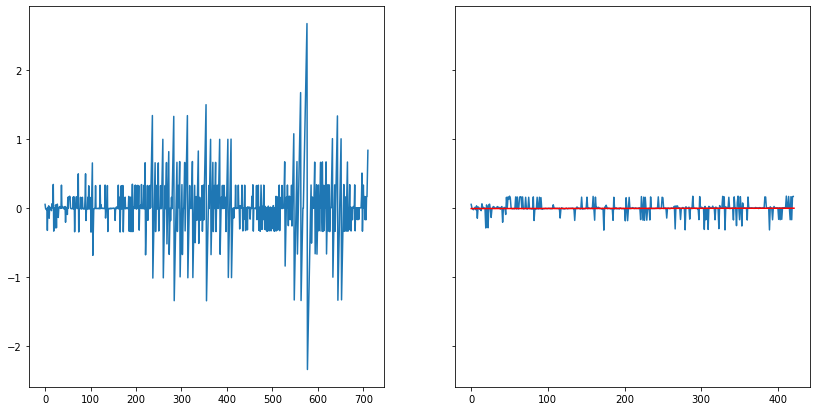

In [511]:
# search for offset (0.001 sec increments)
new_bounds = (max(0, bestcomb2[1]-est_tlen/2), bestcomb2[1]+est_tlen/2)
potential_bpm = [final_bpm]
potential_offset = np.arange(new_bounds[0], new_bounds[1], 0.001)
combs = np.array(np.meshgrid(potential_bpm, potential_offset)).T.reshape(-1,2)
bestcomb4 = searchCombs(combs, 1, used_metric, 1, (est_end, onset_times, 0))
final_offset = bestcomb4[1]

checkTicks(bestcomb4, est_end, onset_times, 1)

In [512]:
final_offset = np.around(final_offset, decimals=3)
final_bpm = np.around(final_bpm, decimals=2)
# if predicted bpm is very close to integer value, round
bpm_shift = final_bpm - round(final_bpm)
if abs(bpm_shift) < 0.05:
    final_bpm = round(final_bpm)

print('[offset bpm meter]: ', final_offset, final_bpm, 4)
sections.append([final_offset, final_bpm, 4])

[offset bpm meter]:  1.36 180.0 4


<IPython.core.display.Javascript object>


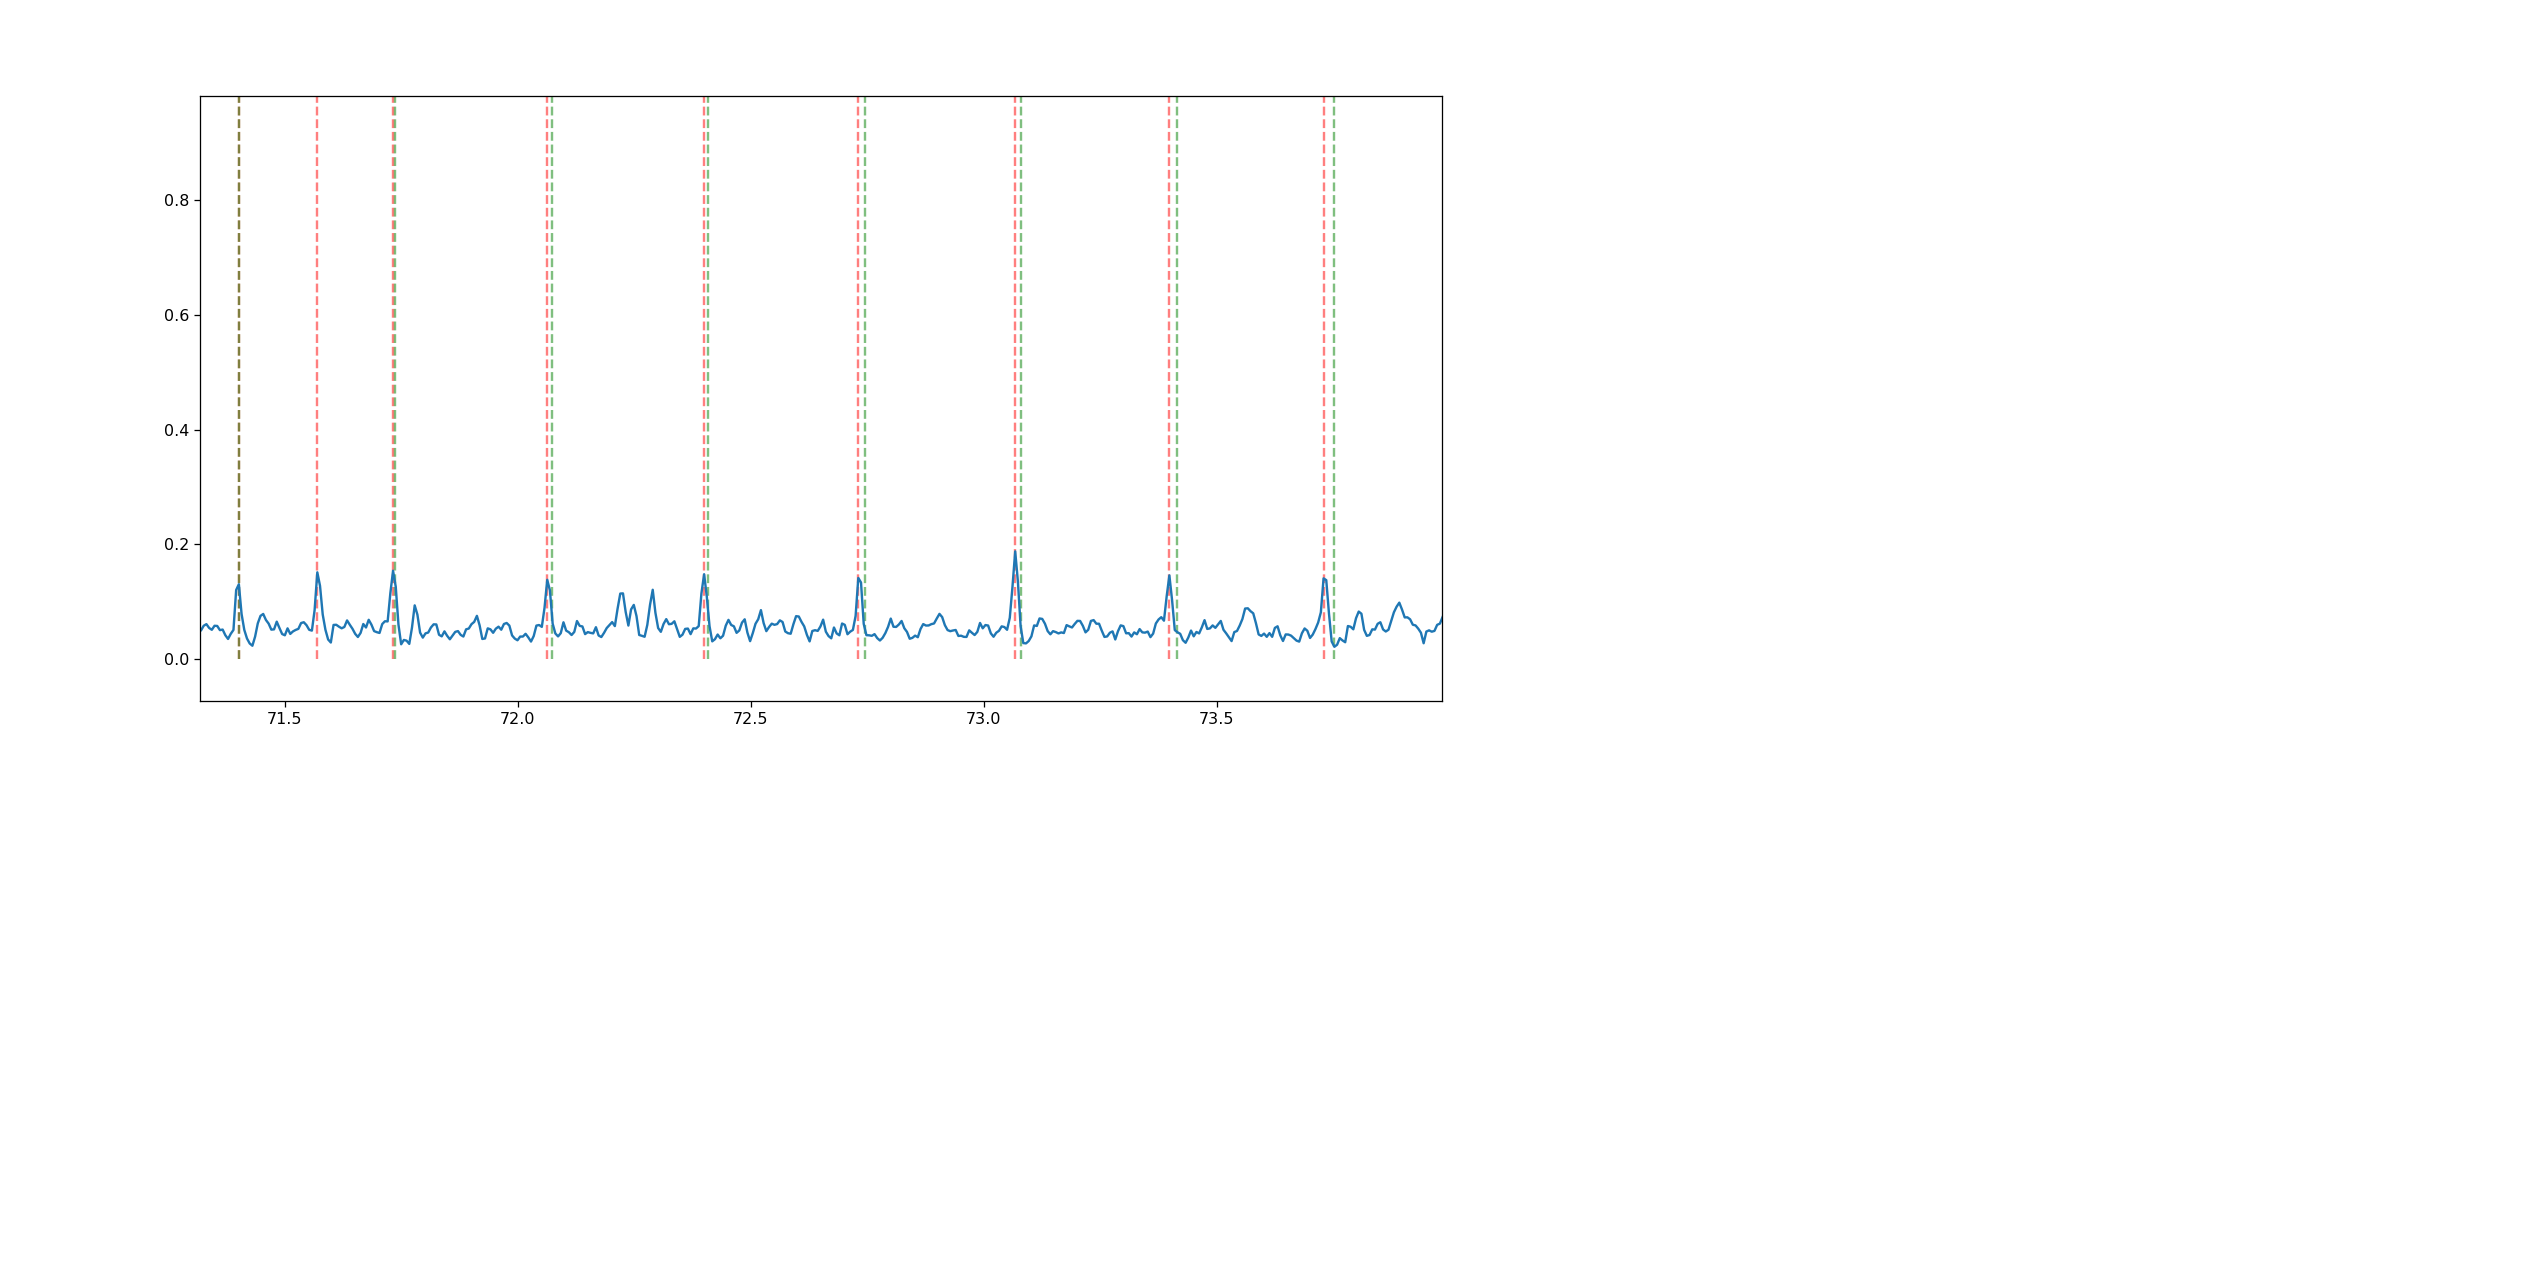

In [455]:
final_beats = createTicks(final_bpm, final_offset, est_end)

%matplotlib notebook
plt.figure(figsize=(14,7))
times = np.arange(len(o_env)) * (hop/sr)
plt.plot(times, librosa.util.normalize(o_env), label='Onset strength')
plt.vlines(onset_times, 0, 1, alpha=0.5, color='r',
           linestyle='--', label='onsets')
plt.vlines(final_beats, 0, 1, alpha=0.5, color='g',
           linestyle='--', label='predicted beats')